In [1]:
import pandas as pd
import torch
import seaborn as sns
import matplotlib.pylab as plt

from monteloanco import Model, GroupedBatchSampler

# Read data

In [2]:
df_jsonl = pd.read_json('accepted_2007_to_2018Q4.jsonl.gz', lines=True).set_index('id')

In [3]:
df = pd.read_csv('monteloanco.csv.gz', index_col='id')
df = df.join(df_jsonl, how='inner').reset_index()

In [4]:
df.pymnt = df.pymnt.apply(torch.tensor)

# Read model

In [5]:
model = Model(embedding_size=4, input_size=len(df), device='cpu')
model.load_state_dict(torch.load('monteloanco.pt', weights_only=True))

<All keys matched successfully>

# Perform test simulation

In [6]:
row = df.sample(1).squeeze()
print(row)
hidden_states, sim_pymnts, interst_payments, principal_payments = model.forward(
    batchidx=0,
    idx=torch.tensor(row.name).repeat(100), 
    installments=torch.tensor(row.installment).repeat(100),
    loan_amnt=torch.tensor(row.loan_amnt).repeat(100), 
    int_rate=torch.tensor(row.int_rate).repeat(100))

id                                                       55575669
0                                                       -1.172362
1                                                       -0.727833
2                                                       -1.786063
3                                                       -0.955052
                                      ...                        
term_numeric                                                   36
installment                                                461.87
loan_amnt                                                   14000
int_rate                                                    11.53
pymnt           [tensor(448.4792), tensor(448.4792), tensor(44...
Name: 28186, Length: 71, dtype: object


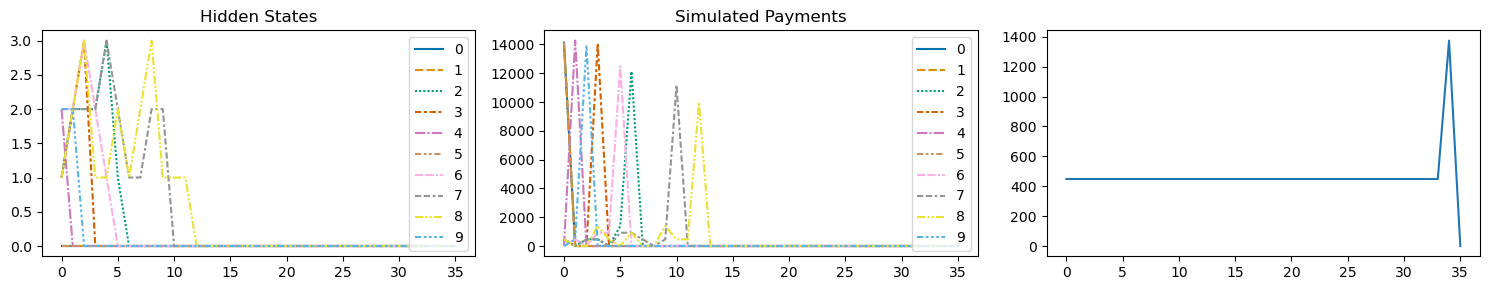

In [7]:
fig, ax = plt.subplots(1, 3, figsize=(15, 3))
sns.lineplot(hidden_states.detach().numpy()[:,:10], ax=ax[0], palette='colorblind')
sns.lineplot(sim_pymnts.detach().numpy()[:,:10], ax=ax[1], palette='colorblind')
sns.lineplot(row.pymnt, ax=ax[2])
ax[0].set_title(f"Hidden States")
ax[1].set_title(f"Simulated Payments")
plt.tight_layout()
plt.show()

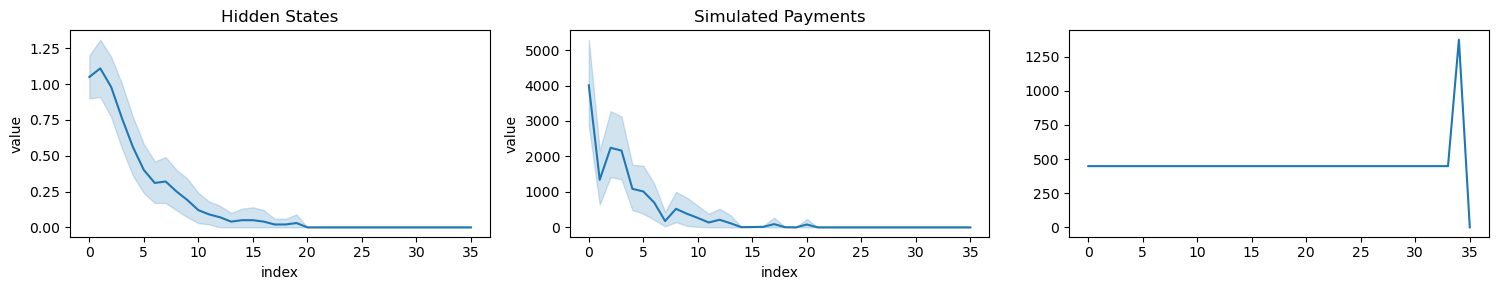

In [8]:
fig, ax = plt.subplots(1, 3, figsize=(15, 3))
sns.lineplot(pd.DataFrame(hidden_states.detach().numpy()).reset_index().melt(id_vars='index'), x='index', y='value', errorbar=('ci', 95), ax=ax[0])
sns.lineplot(pd.DataFrame(sim_pymnts.detach().numpy()).reset_index().melt(id_vars='index'), x='index', y='value', errorbar=('ci', 95), ax=ax[1])
sns.lineplot(row.pymnt, ax=ax[2])
ax[0].set_title(f"Hidden States")
ax[1].set_title(f"Simulated Payments")
plt.tight_layout()
plt.show()

# Simulate full dataset

In [9]:
batch_size = 100_000
dataset = df[['id', 'installment', 'pymnt', 'loan_amnt', 'int_rate']].reset_index(names='idx').to_dict(orient='records')
grouped_batch_sampler = GroupedBatchSampler(dataset, batch_size)

In [10]:
from torch.utils.data import DataLoader

In [11]:
batches = [] 
for batchidx, batch in enumerate(DataLoader(dataset, batch_sampler=grouped_batch_sampler, num_workers=1)):
    batches.append(model.forward(batchidx, batch['idx'], batch['installment'], batch['loan_amnt'], batch['int_rate'], batch['pymnt']))
hidden_states, sim_pymnts, interst_payments, principal_payments = zip(*batches)
#hidden_states = torch.concat(hidden_states, axis=-1)
#sim_pymnts = torch.concat(sim_pymnts, axis=-1)

In [12]:
from itertools import chain

s_sim_pymnts = pd.Series(torch.concat([x.sum(axis=0) for x in sim_pymnts]), index=chain.from_iterable(grouped_batch_sampler.batches))
s_sim_pymnts

0         7263.827491
6        20199.833438
8        28409.151360
11        7096.542045
14       24251.800030
             ...     
98789    18346.629813
99345    35427.290946
99419    17239.922658
99565    23550.859812
99862    14155.517332
Length: 99878, dtype: float64

In [13]:
s_sim_pymnts.sum()

1505656760.4315174

# Score distributions

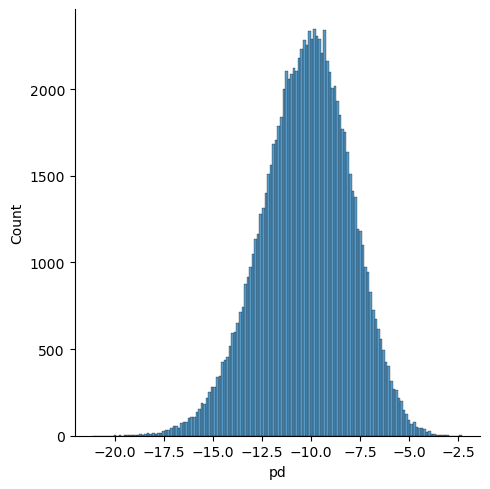

In [14]:
from scipy.special import logit

sns.displot(logit(df.pd), kind='hist')

In [15]:
df['pymnt_sum'] = [x.sum().item() for x in df.pymnt]
df = df.join(s_sim_pymnts.rename('sim_pymnts_sum'))

In [16]:
df['pd_qcut'] = pd.qcut(df.pd, q=11)
df.groupby('pd_qcut', observed=False)[['pymnt_sum', 'sim_pymnts_sum']].sum()

,pymnt_sum,sim_pymnts_sum
pd_qcut,,
"(-0.000999999321, 1.64e-06]",1.089644e+08,1.371673e+08
"(1.64e-06, 4.65e-06]",1.086528e+08,1.378670e+08
"(4.65e-06, 9.56e-06]",1.081681e+08,1.365321e+08
"(9.56e-06, 1.71e-05]",1.078750e+08,1.368277e+08
"(1.71e-05, 2.98e-05]",1.085163e+08,1.376955e+08
"(2.98e-05, 4.99e-05]",1.072330e+08,1.357138e+08
"(4.99e-05, 8.37e-05]",1.077899e+08,1.366972e+08
"(8.37e-05, 0.000145]",1.089165e+08,1.374751e+08
"(0.000145, 0.000274]",1.072813e+08,1.359364e+08


In [17]:
testpds = pd.read_csv('testpds.csv')
testpds = testpds.set_index('0')['1'].rename('testpd')
testpds.sort_index()

0
0        3.554617e-14
1        4.064311e-11
2        1.880126e-16
3        1.803722e-12
4        2.609050e-12
             ...     
99873    6.126037e-13
99874    7.714056e-15
99875    6.856687e-15
99876    2.520586e-19
99877    3.073536e-15
Name: testpd, Length: 99878, dtype: float64

In [18]:
df = df.join(testpds)

In [19]:
df['testpd_qcut'] = pd.qcut(df.testpd, q=11)
df.groupby('testpd_qcut', observed=False)[['pymnt_sum', 'sim_pymnts_sum']].sum()

,pymnt_sum,sim_pymnts_sum
testpd_qcut,,
"(-0.001, 1.95e-16]",9.556549e+07,1.099308e+08
"(1.95e-16, 1.59e-15]",9.124739e+07,1.111020e+08
"(1.59e-15, 6.88e-15]",9.168457e+07,1.164318e+08
"(6.88e-15, 2.39e-14]",9.778181e+07,1.239745e+08
"(2.39e-14, 7.44e-14]",9.958865e+07,1.276558e+08
"(7.44e-14, 2.25e-13]",1.034169e+08,1.336449e+08
"(2.25e-13, 6.87e-13]",1.077278e+08,1.396391e+08
"(6.87e-13, 2.41e-12]",1.107453e+08,1.472248e+08
"(2.41e-12, 1.15e-11]",1.179890e+08,1.555722e+08


In [20]:
df.sort_values('testpd').head(10).pymnt

79569    [tensor(646.7600), tensor(646.7600), tensor(64...
6064     [tensor(666.1384), tensor(666.1384), tensor(66...
77078    [tensor(254.5300), tensor(254.5300), tensor(25...
87367    [tensor(309.8311), tensor(309.8311), tensor(30...
3470     [tensor(442.8200), tensor(442.8200), tensor(44...
54749    [tensor(188.0200), tensor(188.0200), tensor(18...
78457    [tensor(768.1200), tensor(768.1200), tensor(76...
9898     [tensor(269.8350), tensor(269.8350), tensor(11...
78503    [tensor(547.4300), tensor(547.4300), tensor(54...
88515    [tensor(281.1700), tensor(281.1700), tensor(28...
Name: pymnt, dtype: object

In [21]:
df.sort_values('testpd').tail(10).pymnt

3012     [tensor(306.8600), tensor(306.8600), tensor(31...
12046    [tensor(223.7300), tensor(0.), tensor(0.), ten...
47299    [tensor(355.5900), tensor(355.5900), tensor(71...
60592    [tensor(267.7450), tensor(267.7450), tensor(26...
19845    [tensor(325.6200), tensor(325.6200), tensor(32...
18994    [tensor(0.), tensor(0.), tensor(0.), tensor(0....
27407    [tensor(260.0167), tensor(260.0167), tensor(26...
86878    [tensor(260.4417), tensor(260.4417), tensor(26...
33753    [tensor(220.9140), tensor(220.9140), tensor(22...
89759    [tensor(1081.6000), tensor(0.), tensor(0.), te...
Name: pymnt, dtype: object

In [22]:
df['nopay'] = df.pymnt_sum < df.installment

<Axes: xlabel='pymnt_sum', ylabel='testpd'>

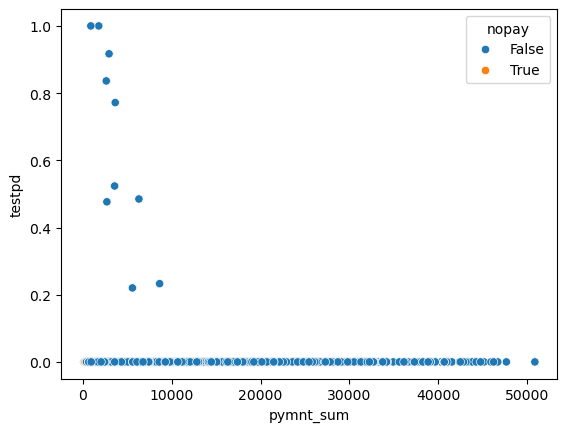

In [23]:
sns.scatterplot(df.sample(1_000), x='pymnt_sum', y='testpd', hue='nopay')

In [24]:
df.groupby('testpd_qcut', observed=False)[['pymnt_sum', 'sim_pymnts_sum', 'nopay']].sum()

,pymnt_sum,sim_pymnts_sum,nopay
testpd_qcut,,,
"(-0.001, 1.95e-16]",9.556549e+07,1.099308e+08,20
"(1.95e-16, 1.59e-15]",9.124739e+07,1.111020e+08,5
"(1.59e-15, 6.88e-15]",9.168457e+07,1.164318e+08,13
"(6.88e-15, 2.39e-14]",9.778181e+07,1.239745e+08,15
"(2.39e-14, 7.44e-14]",9.958865e+07,1.276558e+08,17
"(7.44e-14, 2.25e-13]",1.034169e+08,1.336449e+08,14
"(2.25e-13, 6.87e-13]",1.077278e+08,1.396391e+08,12
"(6.87e-13, 2.41e-12]",1.107453e+08,1.472248e+08,17
"(2.41e-12, 1.15e-11]",1.179890e+08,1.555722e+08,23
